# Gravitational Lensing Example: CNN Embedding + Flow Matching

This notebook demonstrates a Simulation-Based Inference (SBI) workflow for a Strong Lensing task. 

## Conceptual Overview

We aim to infer the parameters $\theta$ of a lensing system (e.g., lens mass, shear) given an observed image $x$.

**Strategy:**
1.  **Compression (VAE)**: We use a **Variational Autoencoder (VAE)** to compress the high-dimensional conditioning data (32x32 images) into a lower-dimensional latent representation.
2.  **Inference (Flow Matching)**: We condition our inference model (a **Flux1** Flow Matching model) on this latent representation.

The encoder is trained end-to-end with the flow matching model to optimize the inference objective.

## Configuration & Data Dimensions

We use the configuration from `config_1a.yaml`.

### Data Dimensions
- **Observation ($\\theta$)**: The target of inference. It has **2 features** (parameters) and **1 channel**.
- **Conditioning ($x$)**: Lensing images. **32x32 pixels** with **1 channel**.

### Processing Pipeline
The conditioning images go through several transformation steps before entering the inference model:

1.  **VAE Encoder**: The 32x32x1 image is processed by the VAE encoder, which outputs a latent feature map of shape **8x8x16**.
2.  **Patchification**: We apply standard Vision Transformer (ViT) patchification with 2x2 patches. 
    - Spatial dimension reduces by factor of 2: $8 \to 4$.
    - Channel dimension increases by factor of $2 \times 2 = 4$: $16 \to 64$.
    - Resulting shape: **4x4x64**.
3.  **Reshaping**: For the Transformer, we flatten the spatial dimensions.
    - $4 \times 4 = 16$ tokens.
    - Each token has size **64**.
    - Resulting array: **16x64**.

The pipeline handles the initialization of condition IDs to represent the patched structure of the image.

## 1. Setup and Imports

First, we set up the environment and import necessary libraries.

In [1]:
import os

if os.environ.get("JAX_PLATFORMS") is None:
    os.environ["JAX_PLATFORMS"] = "cpu"
    os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90"  # use 90% of GPU memory
    # os.environ["JAX_PLATFORMS"] = "cuda"  # change to 'cpu' if no GPU is available

import gensbi

# base libraries
import jax
from jax import Array
from jax import numpy as jnp
import numpy as np
from flax import nnx

from tqdm import tqdm
import gc

# data loading
import grain
from datasets import load_dataset
import yaml

# plotting
import matplotlib.pyplot as plt

# gensbi
from gensbi.recipes import ConditionalFlowPipeline
from gensbi.recipes.flux1 import parse_flux1_params, parse_training_config
from gensbi.recipes.utils import patchify_2d

from gensbi.experimental.models.autoencoders import AutoEncoder2D, AutoEncoderParams
from gensbi.experimental.recipes.vae_pipeline import parse_autoencoder_params
from gensbi.models import Flux1Params, Flux1

from gensbi.utils.plotting import plot_marginals

from gensbi.diagnostics import LC2ST, plot_lc2st
from gensbi.diagnostics import run_sbc, sbc_rank_plot
from gensbi.diagnostics import run_tarp, plot_tarp

config_path = "./config/config_1a.yaml"

## 2. Helper Functions and Classes

In [2]:
def normalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return (batch - mean) / std


def unnormalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return batch * std + mean


class LensingModel(nnx.Module):
    """
    A combined model that first encodes the conditioning data (images) using a VAE,
    and then passes the latent embedding to the SBI model (Flux).
    """
    def __init__(self, vae, sbi_model):
        self.vae = vae
        self.sbi_model = sbi_model

    def __call__(
        self,
        t: Array,
        obs: Array,
        obs_ids: Array,
        cond: Array,
        cond_ids: Array,
        conditioned: bool | Array = True,
        guidance: Array | None = None,
        encoder_key=None,
    ):

        # first we encode the conditioning data
        cond_latent = self.vae.encode(cond, encoder_key)
        # patchify the cond_latent for the transformer
        cond_latent = patchify_2d(cond_latent)

        # then we pass to the sbi model
        return self.sbi_model(
            t=t,
            obs=obs,
            obs_ids=obs_ids,
            cond=cond_latent,
            cond_ids=cond_ids,
            conditioned=conditioned,
            guidance=guidance,
        )

## 3. Data Loading

We load the Lensing dataset.

In [3]:
dim_obs = 2
ch_obs = 1
repo_name = "aurelio-amerio/SBI-benchmarks"
task_name = "lensing"

dataset = load_dataset(repo_name, task_name).with_format("numpy")

df_train = dataset["train"]
df_val = dataset["validation"]
df_test = dataset["test"]

xs_mean = jnp.array([-1.1874731e-05], dtype=jnp.bfloat16).reshape(1, 1, 1)
thetas_mean = jnp.array([0.5996428, 0.15998043], dtype=jnp.bfloat16).reshape(1, 2)

xs_std = jnp.array([1.0440514], dtype=jnp.bfloat16).reshape(1, 1, 1)
thetas_std = jnp.array([0.2886958, 0.08657552], dtype=jnp.bfloat16).reshape(1, 2)

In [5]:
# plot a sample
x_o = df_test["xs"][0][None, ...]
x_o = normalize(jnp.array(x_o, dtype=jnp.bfloat16), xs_mean, xs_std)

theta_true = df_test["thetas"][0]  # already unnormalized

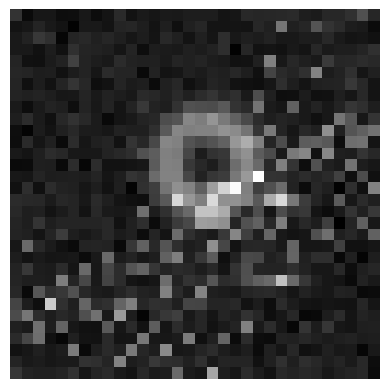

In [12]:
plt.imshow(x_o[0], cmap="gray")
plt.axis("off")
plt.savefig("lensing.png", bbox_inches="tight", dpi=300)
plt.show()

## 4. Model Initialization

In [ ]:
params_dict = parse_autoencoder_params(config_path)

ae_params = AutoEncoderParams(
    rngs=nnx.Rngs(0),
    **params_dict,
)

# define the vae model
vae_model = AutoEncoder2D(ae_params)

# for the sake of the NPE, we delete the decoder model as it is not needed
vae_model.Decoder1D = None
# run the garbage collector to free up memory
gc.collect()

# now we define the NPE pipeline
# get the latent dimensions from the autoencoder
latent_dim1 = vae_model.latent_shape[1]
latent_dim2 = vae_model.latent_shape[2]

# After 2x2 patchification, dimensions are halved
dim_cond_latent = (latent_dim1 // 2) * (latent_dim2 // 2)
# Channels are multiplied by 4 (2x2)
ch_cond_latent = vae_model.latent_shape[3] * 4

print(f"Original Latent Shape: {vae_model.latent_shape}")
print(f"Conditioning Transformer Input: {dim_cond_latent} tokens of size {ch_cond_latent}")

params_dict_flux = parse_flux1_params(config_path)
assert (
    params_dict_flux["context_in_dim"] == ch_cond_latent
), "Context dimension mismatch, got {} expected {}".format(
    params_dict_flux["context_in_dim"], ch_cond_latent
)

params_flux = Flux1Params(
    rngs=nnx.Rngs(0),
    dim_obs=dim_obs,
    dim_cond=dim_cond_latent,
    **params_dict_flux,
)

model_sbi = Flux1(params_flux)

model = LensingModel(vae_model, model_sbi)

## 5. Pipeline Setup and Restoration

In [ ]:
training_config = parse_training_config(config_path)

with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    batch_size = config["training"]["batch_size"]
    nsteps = config["training"]["nsteps"]
    multistep = config["training"]["multistep"]
    experiment = config["training"]["experiment_id"]

def split_data(batch):
    obs = jnp.array(batch["thetas"], dtype=jnp.bfloat16)
    obs = normalize(obs, thetas_mean, thetas_std)
    obs = obs.reshape(obs.shape[0], dim_obs, ch_obs)
    cond = jnp.array(batch["xs"], dtype=jnp.bfloat16)
    cond = normalize(cond, xs_mean, xs_std)
    cond = cond[..., None]
    return obs, cond

train_dataset_npe = (
    grain.MapDataset.source(df_train).shuffle(42).repeat().to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
    ds=train_dataset_npe,
    ram_budget_mb=1024 * 8,
    max_workers=None,
    max_buffer_size=None,
)

train_dataset_npe = (
    train_dataset_npe.batch(batch_size)
    .map(split_data)
    .mp_prefetch(performance_config.multiprocessing_options)
)

val_dataset_npe = (
    grain.MapDataset.source(df_val)
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(256)
    .map(split_data)
)

training_config["checkpoint_dir"] = (
    "/lhome/ific/a/aamerio/data/github/GenSBI-examples/examples/sbi-benchmarks/lensing/npe_v1a/checkpoints"
)

pipeline_latent = ConditionalFlowPipeline(
    model,
    train_dataset_npe,
    val_dataset_npe,
    dim_obs=dim_obs,
    dim_cond=(
        latent_dim1,
        latent_dim2,
    ),  # we are workin in the latent space of the vae
    ch_obs=ch_obs,
    ch_cond=ch_cond_latent,  # conditioning is now in the latent space
    training_config=training_config,
    id_embedding_strategy=("absolute", "rope2d"),
)

print("Restoring model...")
pipeline_latent.restore_model()
print("Done!")

## 6. Inference and Visualization

We generate samples and visualize the posterior for a test observation.

In [ ]:
x_o = df_test["xs"][0][None, ...]
x_o = normalize(jnp.array(x_o, dtype=jnp.bfloat16), xs_mean, xs_std)
x_o = x_o[..., None]

theta_true = df_test["thetas"][0]  # already unnormalized

print("Sampling 100,000 samples...")
samples = pipeline_latent.sample_batched(
    nnx.Rngs(0).sample(),
    x_o,
    100_000,
    chunk_size=10_000,
    encoder_key=jax.random.PRNGKey(1234),
)

res = samples[:, 0, :, 0]  # shape (num_samples, 1, 2, 1) -> (num_samples, 2)
# unnormalize the results for plotting
res_unnorm = unnormalize(res, thetas_mean, thetas_std)

plot_marginals(res_unnorm, true_param=theta_true, gridsize=30)
plt.title(f"Lensing Samples (Exp {experiment})")
# plt.savefig(f"lensing_samples_conf{experiment}.png", dpi=100, bbox_inches="tight")
plt.show()

## 7. Diagnostics

We run several diagnostics to validate the quality of the posterior estimation.

### TARP (Test of Accuracy and Reliability of Posterior)

In [ ]:
# # split in thetas and xs
thetas_ = np.array(df_test["thetas"])[:200]
xs_ = np.array(df_test["xs"])[:200]

thetas_ = normalize(jnp.array(thetas_, dtype=jnp.bfloat16), thetas_mean, thetas_std)
xs_ = normalize(jnp.array(xs_, dtype=jnp.bfloat16), xs_mean, xs_std)
xs_ = xs_[..., None]

num_posterior_samples = 1000

print("Sampling for TARP...")
posterior_samples_ = pipeline_latent.sample_batched(
    jax.random.PRNGKey(42),
    xs_,
    num_posterior_samples,
    chunk_size=20,
    encoder_key=jax.random.PRNGKey(1234),
)

thetas = thetas_.reshape(thetas_.shape[0], -1)
xs = xs_.reshape(xs_.shape[0], -1)

posterior_samples = posterior_samples_.reshape(
    posterior_samples_.shape[0], posterior_samples_.shape[1], -1
)

ecp, alpha = run_tarp(
    thetas,
    posterior_samples,
    references=None,  # will be calculated automatically.
)

plot_tarp(ecp, alpha)
# plt.savefig(
#     f"lensing_tarp_v1a_conf{experiment}.png", dpi=100, bbox_inches="tight"
# )  # uncomment to save the figure
plt.show()

### SBC (Simulation-Based Calibration)

In [ ]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_samples)

f, ax = sbc_rank_plot(ranks, num_posterior_samples, plot_type="hist", num_bins=20)
# plt.savefig(
#     f"lensing_sbc_v1a_conf{experiment}.png", dpi=100, bbox_inches="tight"
# )  # uncomment to save the figure
plt.show()

### LC2ST (Local Classifier 2-Sample Test)
This tests if the posterior samples are distinguishable from the true parameters.

In [ ]:
thetas_ = np.array(df_test["thetas"])[:10_000]
xs_ = np.array(df_test["xs"])[:10_000]

thetas_ = normalize(jnp.array(thetas_, dtype=jnp.bfloat16), thetas_mean, thetas_std)
xs_ = normalize(jnp.array(xs_, dtype=jnp.bfloat16), xs_mean, xs_std)
xs_ = xs_[..., None]

num_posterior_samples = 1

posterior_samples_ = pipeline_latent.sample(
    jax.random.PRNGKey(42),
    x_o=xs_,
    nsamples=xs_.shape[0],
    encoder_key=jax.random.PRNGKey(1234),
)

thetas = thetas_.reshape(thetas_.shape[0], -1)
xs = xs_.reshape(xs_.shape[0], -1)
posterior_samples = posterior_samples_.reshape(posterior_samples_.shape[0], -1)

# Train the L-C2ST classifier.
lc2st = LC2ST(
    thetas=thetas[:-1],
    xs=xs[:-1],
    posterior_samples=posterior_samples[:-1],
    classifier="mlp",
    num_ensemble=1,
)

_ = lc2st.train_under_null_hypothesis()
_ = lc2st.train_on_observed_data()

x_o = xs_[-1:]  # Take the last observation as observed data.
theta_o = thetas_[-1:]  # True parameter for the observed data.

post_samples_star = pipeline_latent.sample(
    jax.random.PRNGKey(42), x_o, nsamples=10_000
)

x_o = x_o.reshape(1, -1)
post_samples_star = np.array(
    post_samples_star.reshape(post_samples_star.shape[0], -1)
)

fig, ax = plot_lc2st(
    lc2st,
    post_samples_star,
    x_o,
)
# plt.savefig(
#     f"lensing_lc2st_v1a_conf{experiment}.png", dpi=100, bbox_inches="tight"
# )  # uncomment to save the figure
plt.show()